In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re
from collections import OrderedDict


In [2]:
var_name = 'solar_rad'

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

# For the data generator all variables have to be merged into a single dataset.
if var_name == 'specific_humidity':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'specific_humidity': ('q', [500, 850])}
elif var_name == '2m temp':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        '2m_temperature': ('t2m', None)}
elif var_name == 'solar_rad':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'toa_incident_solar_radiation': ('tisr', None)}
elif var_name == 'pot_vort':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'potential_vorticity': ('pv', [500, 850])}
elif var_name == 'const':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'constants': ['lat2d', 'orography', 'lsm']}
elif var_name == 'orig':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850])} 

ds_list = []

for long_var, params in var_dict.items():
    if long_var == 'constants':
        ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))
    else:
        var, levels = params
        if levels is not None:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords').sel(level = levels))
        else:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))

print('got here')

ds_whole = xr.merge(ds_list)
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))


class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, 
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants': 
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values) 
                                if any([bool(re.match(o, l)) for o in output_vars])]
        
        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

bs=32
lead_time=72
output_vars = ['z_500', 't_850']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, 
                         shuffle=False, output_vars=output_vars)

got here
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [4]:
dg_test.data

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64, level: 3)>
array([[[[-0.941001  , -1.0699282 ,  0.470836  ],
         [-0.9331867 , -1.0644817 ,  0.46922857],
         [-0.92634875, -1.0637459 ,  0.4693357 ],
         ...,
         [-0.9595587 , -1.0345917 ,  0.48417786],
         [-0.9536983 , -1.0512305 ,  0.47828382],
         [-0.9478378 , -1.0625677 ,  0.47378308]],

        [[-1.0201182 , -0.91562665,  0.14538269],
         [-0.9898385 , -0.9302027 ,  0.1409354 ],
         [-0.96248895, -0.9729016 ,  0.14104262],
         ...,
         [-1.0943526 , -0.92887783,  0.18556915],
         [-1.0738411 , -0.93830097,  0.16788721],
         [-1.0503992 , -0.9499337 ,  0.154331  ]],

        [[-1.0171881 , -0.72937435, -0.18859008],
         [-0.94881415, -0.7323197 , -0.19609147],
         [-0.89606893, -0.8361196 , -0.19598426],
         ...,
...
         ...,
         [-0.9557197 , -1.1627803 , -0.74626505],
         [-1.0115443 , -1.2812649 , -0.74626505],
         [-1.1124175 , -1.3970126 , -0.74626505]],

        [[-1.4287561 , -1.6065636 , -0.74626505],
         [-1.4806625 , -1.7048455 , -0.74626505],
         [-1.5355072 , -1.7361622 , -0.74626505],
         ...,
         [-1.3053545 , -1.620851  , -0.74626505],
         [-1.3415915 , -1.600937  , -0.74626505],
         [-1.3817455 , -1.5485479 , -0.74626505]],

        [[-1.6314858 , -1.5662992 , -0.74626505],
         [-1.6628246 , -1.5544649 , -0.74626505],
         [-1.697103  , -1.5398889 , -0.74626505],
         ...,
         [-1.5580332 , -1.6077182 , -0.74626505],
         [-1.5795783 , -1.5970386 , -0.74626505],
         [-1.6040616 , -1.5836172 , -0.74626505]]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time         (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level        (level) int64 500 850 1
    level_names  (level) <U5 'z_500' 't_850' 'tisr'

In [7]:
dg_train.data

<xarray.DataArray 'z' (time: 324336, lat: 32, lon: 64, level: 3)>
array([[[[-0.7608754 , -0.9196875 ,         nan],
         [-0.754034  , -0.9220301 ,         nan],
         [-0.74523747, -0.92378753,         nan],
         ...,
         [-0.7794448 , -0.9009448 ,         nan],
         [-0.77358085, -0.9038746 ,         nan],
         [-0.7677169 , -0.91339165,         nan]],

        [[-0.8830431 , -0.9918752 ,         nan],
         [-0.8889071 , -0.8805935 ,         nan],
         [-0.8674052 , -0.93608755,         nan],
         ...,
         [-0.87229276, -0.85672534,         nan],
         [-0.8703377 , -0.87151474,         nan],
         [-0.8732703 , -0.966688  ,         nan]],

        [[-0.94168377, -0.74764144,         nan],
         [-0.9661171 , -0.8778106 ,         nan],
         [-0.9602531 , -0.9192491 ,         nan],
         ...,
...
         ...,
         [-1.2014102 , -0.8065427 , -0.74626505],
         [-1.0562888 , -0.5696224 , -0.74626505],
         [-0.92391485, -0.48124015, -0.74626505]],

        [[-1.176893  , -0.79102135, -0.74626505],
         [-1.1033518 , -0.69093007, -0.74626505],
         [-1.0278499 , -0.6484954 , -0.74626505],
         ...,
         [-1.3396643 , -0.84779924, -0.74626505],
         [-1.2994615 , -0.86389595, -0.74626505],
         [-1.2445514 , -0.88994235, -0.74626505]],

        [[-1.62304   , -0.8186784 , -0.74626505],
         [-1.6004871 , -0.8008262 , -0.74626505],
         [-1.5710719 , -0.7683411 , -0.74626505],
         ...,
         [-1.6387292 , -0.74858665, -0.74626505],
         [-1.642651  , -0.78355914, -0.74626505],
         [-1.6377482 , -0.8084352 , -0.74626505]]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time         (time) datetime64[ns] 1979-01-01 ... 2015-12-31T23:00:00
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level        (level) int64 500 850 1
    level_names  (level) <U5 'z_500' 't_850' 'tisr'

In [23]:
np.array(ds_whole.tisr.isel(time = 6))

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [24]:
data_array = np.array(ds_train.tisr)

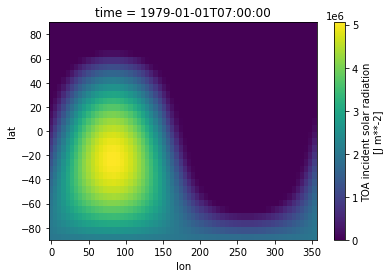

In [31]:
ds_whole.tisr.isel(time = 7).plot()

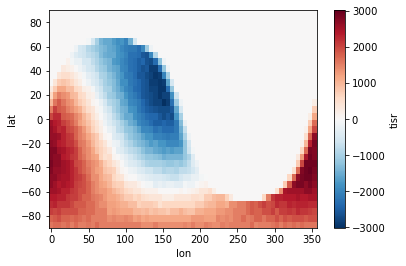

In [40]:
(ds_whole.tisr.isel(time = 7+(365*24))-ds_whole.tisr.isel(time = 7)).plot()

In [45]:
ds_whole.tisr.isel(time = 6).data = ds_whole.tisr.isel(time = 6+(365*24)).data

In [51]:
ds_whole.isel(time = slice(7, None))

,Array,Chunk
Bytes,5.74 GB,143.92 MB
Shape,"(350633, 2, 32, 64)","(8784, 2, 32, 64)"
Count,527 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.74 GB,143.92 MB
Shape,"(350633, 2, 32, 64)","(8784, 2, 32, 64)"
Count,527 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
